# ML Project Example - Regression
**Dr. Heba El-Shimy**
### Using Infrared Thermography Temperature Dataset
Link: [https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset](https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset)

<a id="toc"></a>

## Steps of a Data Science / Machine Learning Project
Based on content by Andrew Ng - Stanford CS230 2025: [https://youtu.be/MGqQuQEUXhk?si=aRe2kOIUhRCAgeeT](https://youtu.be/MGqQuQEUXhk?si=aRe2kOIUhRCAgeeT)

1. [Specify the problem](#step-1)
2. [Get the data -- Exploratory Data Analysis (EDA)](#step-2)
3. [Design the model](#step-3)
4. [Train the model](#step-3)
5. [Evaluate the model's performance](#step-4)
5. Iterate through steps 2-5 in a rapid development loop
6. Deploy the model (not covered)
7. Monitor / maintain the model (not covered)

<hr height="5px"/>

<a id="step-1"></a>

### Step 1: Specifying the problem

We need to develop a ML model that can predict the oral temperature of a person from the readings of an infrared camera in various ambient temperatures and with high accuracy. This will be helpful for infection control in certain healthcare facilities and public service centers.

<hr height="5px"/>

<a id="step-2"></a>

### Step 2: Get the data

We have a dataset from UCI repository: [https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset](https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset)

The detailed description of the dataset is found in the link above. The dataset contains multiple files corresponding to different ambient temperatures (Group 1 and Group 2) and different cameras (ICI and FLIR). Based on the description of the dataset and the results of its analysis in the accompanying publication ([https://pmc.ncbi.nlm.nih.gov/articles/PMC11046542/](https://pmc.ncbi.nlm.nih.gov/articles/PMC11046542/)), I decided to use data from both Groups 1 and 2 for the FLIR camera only.

**Note:** For simplicity here, I skipped the EDA step, especially that the publication had a detailed analysis of the data.
I added feature engineering in this section.

In [55]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')

In [2]:
# Load the data - row 3 (index 2) contains the column names
df = pd.read_csv("dataset_reg/FLIR_groups1and2.csv", header=2)

# Remove the first row which is a duplicate of column names
df = df.iloc[1:].reset_index(drop=True)

# Drop unnamed/empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed', na=False)]
df = df.dropna(axis=1, how='all')

print(f"Dataset Shape: {df.shape[0]} samples, {df.shape[1]} features")
print("-"*70)
print("Dataset description")
print(df.info())
print("-"*70)
print(f"First 5 rows of the dataset")
df.head()

Dataset Shape: 1019 samples, 120 features
----------------------------------------------------------------------
Dataset description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Columns: 120 entries, SubjectID to Date
dtypes: float64(114), object(6)
memory usage: 955.4+ KB
None
----------------------------------------------------------------------
First 5 rows of the dataset


,SubjectID,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,...,aveOralM,Gender,Age,Ethnicity,T_atm,Humidity,Distance,Cosmetics,Time,Date
0,161117-2,0.83,34.71,34.51,34.46,34.24,34.68,34.68,34.44,34.71,...,37.19,Female,31-40,Black or African-American,24.0,26.0,0.8,NaN,15:22:48,16-11-17
1,161117-3,0.85,35.70,35.44,35.00,34.78,35.67,35.67,35.46,35.70,...,37.34,Female,21-30,White,24.0,26.0,0.8,NaN,15:52:56,16-11-17
2,161117-4,0.90,35.17,35.50,34.25,35.00,35.14,35.14,35.08,35.17,...,37.09,Female,21-30,Black or African-American,24.0,27.0,0.8,NaN,16:07:53,16-11-17
3,161117-5,1.08,35.33,35.55,34.31,35.14,35.50,35.30,35.50,35.52,...,37.04,Male,18-20,White,24.0,27.0,0.8,NaN,16:28:06,16-11-17
4,161117-6,0.86,34.95,35.10,34.30,34.59,34.97,34.97,34.85,34.98,...,36.99,Female,21-30,White,24.0,26.0,0.8,NaN,16:43:28,16-11-17


In [3]:
# Identify non-numeric columns
non_numeric_cols = ['SubjectID', 'Gender', 'Age', 'Ethnicity', 'Cosmetics', 'Time', 'Date']

# Convert all other columns to numeric
for col in df.columns:
    if col not in non_numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print(df.info())
print("-"*70)
print("First 5 rows:")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Columns: 120 entries, SubjectID to Date
dtypes: float64(114), object(6)
memory usage: 955.4+ KB
None
----------------------------------------------------------------------
First 5 rows:


,SubjectID,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,...,aveOralM,Gender,Age,Ethnicity,T_atm,Humidity,Distance,Cosmetics,Time,Date
0,161117-2,0.83,34.71,34.51,34.46,34.24,34.68,34.68,34.44,34.71,...,37.19,Female,31-40,Black or African-American,24.0,26.0,0.8,NaN,15:22:48,16-11-17
1,161117-3,0.85,35.70,35.44,35.00,34.78,35.67,35.67,35.46,35.70,...,37.34,Female,21-30,White,24.0,26.0,0.8,NaN,15:52:56,16-11-17
2,161117-4,0.90,35.17,35.50,34.25,35.00,35.14,35.14,35.08,35.17,...,37.09,Female,21-30,Black or African-American,24.0,27.0,0.8,NaN,16:07:53,16-11-17
3,161117-5,1.08,35.33,35.55,34.31,35.14,35.50,35.30,35.50,35.52,...,37.04,Male,18-20,White,24.0,27.0,0.8,NaN,16:28:06,16-11-17
4,161117-6,0.86,34.95,35.10,34.30,34.59,34.97,34.97,34.85,34.98,...,36.99,Female,21-30,White,24.0,26.0,0.8,NaN,16:43:28,16-11-17


In [11]:
# Remove rows with any missing values
df_clean = df.dropna()
print(f"Rows removed: {len(df) - len(df_clean)} ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")

print("-"*70)
print("Clean dataset shape:", df_clean.shape)
print("\nNo missing values remaining:", df_clean.isnull().sum().sum(), "total null values")

Rows removed: 86 (8.4%)
----------------------------------------------------------------------
Clean dataset shape: (933, 120)

No missing values remaining: 0 total null values


In [12]:
# Encoding Categorical Variables

# 1. GENDER: Label Encoding
print("1. Encoding GENDER (Label Encoding)")
print("-"*70)
if 'Gender' in df_clean.columns:
    print("Original values:", df_clean['Gender'].unique())
    
    # Create encoded version
    df_clean['Gender_encoded'] = df_clean['Gender'].map({'Male': 0, 'Female': 1})
    print("Encoded values:  Male=0, Female=1")
    print(f"Missing values: {df_clean['Gender_encoded'].isnull().sum()}")

# 2. AGE: Ordinal Encoding
print("\n" + "="*70)
print("2. Encoding AGE (Ordinal Encoding)")
print("-"*70)
if 'Age' in df_clean.columns:
    print("Original values:", sorted(df_clean['Age'].unique()))
    
    # Create age mapping (preserving order)
    age_mapping = {
        '18-20': 1,
        '21-25': 2,
        '21-30': 2,
        '26-30': 3,
        '31-40': 4,
        '41-50': 5,
        '51-60': 6,
        '>60': 7
    }
    
    df_clean['Age_encoded'] = df_clean['Age'].map(age_mapping)
    print("\nAge group ordering:")
    for age_group, code in age_mapping.items():
        print(f"  {age_group:10s} → {code}")
    
    print(f"\nMissing values: {df_clean['Age_encoded'].isnull().sum()}")

# 3. ETHNICITY: One-Hot Encoding
print("\n" + "="*70)
print("3. Encoding ETHNICITY (One-Hot Encoding)")
print("-"*70)
if 'Ethnicity' in df_clean.columns:
    print("Original values:", df_clean['Ethnicity'].unique())
    print(f"Number of categories: {df_clean['Ethnicity'].nunique()}")
    
    # Create one-hot encoded columns
    ethnicity_dummies = pd.get_dummies(df_clean['Ethnicity'], prefix='Ethnicity')
    
    print(f"\nCreated {len(ethnicity_dummies.columns)} dummy variables:")
    for col in ethnicity_dummies.columns:
        print(f"  - {col}")
    
    # Add to dataframe
    df_clean = pd.concat([df_clean, ethnicity_dummies], axis=1)
    
# Drop original (non-encoded columns)
df_clean = df_clean.drop(columns=['Gender', 'Age', 'Ethnicity'])

# Show final column count
print(f"\nDataset now has {df_clean.shape[1]} columns")

1. Encoding GENDER (Label Encoding)
----------------------------------------------------------------------
Original values: ['Female' 'Male']
Encoded values:  Male=0, Female=1
Missing values: 0

Mapping:
    Gender  Gender_encoded
29    Male               0
26  Female               1

2. Encoding AGE (Ordinal Encoding)
----------------------------------------------------------------------
Original values: ['18-20', '21-25', '21-30', '26-30', '31-40', '41-50', '51-60', '>60']

Age group ordering:
  18-20      → 1
  21-25      → 2
  21-30      → 2
  26-30      → 3
  31-40      → 4
  41-50      → 5
  51-60      → 6
  >60        → 7

Missing values: 0

3. Encoding ETHNICITY (One-Hot Encoding)
----------------------------------------------------------------------
Original values: ['Asian' 'Hispanic/Latino' 'White' 'Black or African-American'
 'Multiracial' 'American Indian or Alaskan Native']
Number of categories: 6

Created 6 dummy variables:
  - Ethnicity_American Indian or Alaskan Native

In [13]:
# Separate columns by round
round1_cols = [col for col in df_clean.columns if col.endswith('_1') or col.endswith('1')]
round2_cols = [col for col in df_clean.columns if col.endswith('_2') or col.endswith('2')]
round3_cols = [col for col in df_clean.columns if col.endswith('_3') or col.endswith('3')]
round4_cols = [col for col in df_clean.columns if col.endswith('_4') or col.endswith('4')]
other_cols = [col for col in df_clean.columns if col not in round1_cols + round2_cols + round3_cols + round4_cols]

print(f"Round 1 features: {len(round1_cols)}")
for i, col in enumerate(round1_cols, 1):
    print(f"{i}. {col}")
    
print("-"*70)
print(f"Other features: {len(other_cols)}")
for i, col in enumerate(other_cols, 1):
    print(f"{i}. {col}")

Round 1 features: 27
1. T_offset1
2. Max1R13_1
3. Max1L13_1
4. aveAllR13_1
5. aveAllL13_1
6. T_RC1
7. T_RC_Dry1
8. T_RC_Wet1
9. T_RC_Max1
10. T_LC1
11. T_LC_Dry1
12. T_LC_Wet1
13. T_LC_Max1
14. RCC1
15. LCC1
16. canthiMax1
17. canthi4Max1
18. T_FHCC1
19. T_FHRC1
20. T_FHLC1
21. T_FHBC1
22. T_FHTC1
23. T_FH_Max1
24. T_FHC_Max1
25. T_Max1
26. T_OR1
27. T_OR_Max1
----------------------------------------------------------------------
Other features: 17
1. SubjectID
2. aveOralF
3. aveOralM
4. T_atm
5. Humidity
6. Distance
7. Cosmetics
8. Time
9. Date
10. Gender_encoded
11. Age_encoded
12. Ethnicity_American Indian or Alaskan Native
13. Ethnicity_Asian
14. Ethnicity_Black or African-American
15. Ethnicity_Hispanic/Latino
16. Ethnicity_Multiracial
17. Ethnicity_White


**Feature Engineering**

In [15]:
# Feature engineering: Three feature sets for three experiments

# EXPERIMENT 1: Domain Knowledge (from published paper)
features_exp1 = [
    'canthiMax1',      # Inner canthi maximum (r=0.82 per research)
    'T_Max1',          # Full face maximum (r=0.82 per research)
    'T_atm',           # Ambient temperature
    'Humidity',        # Relative humidity
]
print(f"Exp 1: {len(features_exp1)}, {features_exp1} features (Experiment 1--Domain Knowledge)")
df_clean[features_exp1].head()

Exp 1: 4, ['canthiMax1', 'T_Max1', 'T_atm', 'Humidity'] features (Experiment 1--Domain Knowledge)


,canthiMax1,T_Max1,T_atm,Humidity
26,35.09,35.61,22.5,34.5
27,36.12,36.12,23.4,27.3
28,35.15,35.32,23.2,27.2
29,35.90,35.94,23.1,27.0
30,34.99,35.28,22.8,33.0


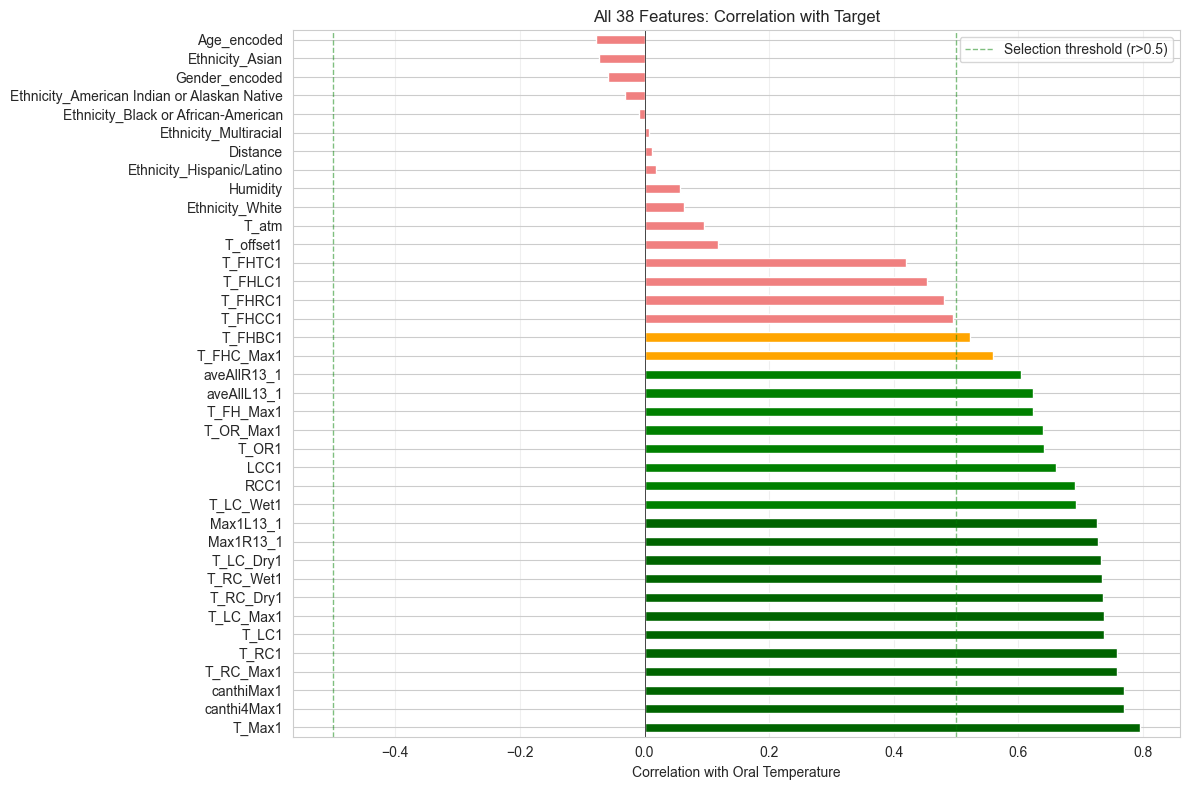

Top 10 features by correlation:
----------------------------------------------------------------------
T_Max1                        :  0.794
canthi4Max1                   :  0.770
canthiMax1                    :  0.770
T_RC_Max1                     :  0.758
T_RC1                         :  0.757
T_LC1                         :  0.737
T_LC_Max1                     :  0.737
T_RC_Dry1                     :  0.736
T_RC_Wet1                     :  0.734
T_LC_Dry1                     :  0.733
Max1R13_1                     :  0.727
Max1L13_1                     :  0.726
T_LC_Wet1                     :  0.692
RCC1                          :  0.691
LCC1                          :  0.660
----------------------------------------------------------------------
Removing redundant features
  Removing canthi4Max1                    (r=0.946 with T_Max1)
  Removing canthiMax1                     (r=0.946 with T_Max1)
  Removing T_RC_Max1                      (r=0.921 with T_Max1)
  Removing T_RC1     

,T_Max1,T_OR1,T_FH_Max1,aveAllL13_1,aveAllR13_1,T_FHC_Max1
26,35.61,34.13,35.61,34.67,34.53,34.74
27,36.12,34.95,35.54,35.27,35.50,34.93
28,35.32,34.40,35.18,34.29,33.72,34.83
29,35.94,35.90,35.55,35.27,34.99,35.19
30,35.28,35.25,34.77,33.72,34.61,34.45


In [21]:
# EXPERIMENT 2: Correlation analysis and feature engineering

# Step 1: Get all round 1 features + environmental and demographic features in one set
feature_set = [col for col in round1_cols if col in df.columns]
feature_set.extend(['T_atm', 'Humidity', 'Distance', 'Gender_encoded', 'Age_encoded', 
                   'Ethnicity_American Indian or Alaskan Native', 'Ethnicity_Asian',
                   'Ethnicity_Black or African-American', 'Ethnicity_Hispanic/Latino',
                   'Ethnicity_Multiracial', 'Ethnicity_White'])

target_col = 'aveOralM'

# Remove duplicates
feature_set = list(set(feature_set))

# Step 2: Calculate correlations with target
correlations_all = df_clean[feature_set].corrwith(df_clean[target_col]).sort_values(ascending=False)

# Visualize all correlations
plt.figure(figsize=(12, 8))
colors = ['darkgreen' if abs(x) > 0.7 else 'green' if abs(x) > 0.6 else 'orange' if abs(x) > 0.5 else 'lightcoral' for x in correlations_all.values]
correlations_all.plot(kind='barh', color=colors)
plt.xlabel('Correlation with Oral Temperature')
plt.title(f'All {len(feature_set)} Features: Correlation with Target')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Selection threshold (r>0.5)')
plt.axvline(x=-0.5, color='green', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Top 10 features by correlation:")
print("-"*70)
for feat, corr in correlations_all.head(15).items():
    print(f"{feat:30s}: {corr:6.3f}")

# Step 2: Get features with strong correlation (|r| > 0.5)
correlation_threshold = 0.5
strong_features = correlations_all[abs(correlations_all) > correlation_threshold].index.tolist()

# Step 3: Check for multicollinearity among selected features
print("-"*70)
print("Removing redundant features")

# Calculate correlation matrix for selected features
correlation_matrix = df_clean[strong_features].corr()

# Find highly correlated pairs
multicollinearity_threshold = 0.9
redundant_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > multicollinearity_threshold:
            feat1 = correlation_matrix.columns[i]
            feat2 = correlation_matrix.columns[j]
            corr_val = correlation_matrix.iloc[i, j]
            
            # Keep the feature with higher correlation to target
            corr_feat1 = abs(correlations_all[feat1])
            corr_feat2 = abs(correlations_all[feat2])
            
            if corr_feat1 >= corr_feat2:
                redundant_features.add(feat2)
                print(f"  Removing {feat2:30s} (r={corr_val:.3f} with {feat1})")
            else:
                redundant_features.add(feat1)
                print(f"  Removing {feat1:30s} (r={corr_val:.3f} with {feat2})")

# Create final feature set for Experiment 2
features_exp2 = [f for f in strong_features if f not in redundant_features]

# EXPERIMENT 2: Engineered features
print("Experiment 2: {len(features_exp3)} features")
print("-"*70)
for i, feat in enumerate(features_exp2, 1):
    corr = correlations_all[feat]
    print(f"{i:2d}. {feat:30s}  r={corr:6.3f}")
    
df_clean[features_exp2].head()

In [22]:
# EXPERIMENT 3: All Round 1 Features + environmental and demographic features
features_exp3 = [col for col in round1_cols if col in df.columns]
features_exp3.extend(['T_atm', 'Humidity', 'Distance', 'Gender_encoded', 'Age_encoded', 
                   'Ethnicity_American Indian or Alaskan Native', 'Ethnicity_Asian',
                   'Ethnicity_Black or African-American', 'Ethnicity_Hispanic/Latino',
                   'Ethnicity_Multiracial', 'Ethnicity_White'
                ])

# Remove duplicates
features_exp3 = list(set(features_exp3))
print(f"Exp 3: {len(features_exp3)} features (Experiment 3--Full Round 1 Features)")
df_clean[features_exp3].head()

Exp 3: 38 features (Experiment 3--Full Round 1 Features)


,T_LC_Wet1,T_offset1,canthi4Max1,aveAllR13_1,Distance,T_OR1,T_RC_Wet1,Max1R13_1,Ethnicity_American Indian or Alaskan Native,T_OR_Max1,...,T_LC_Max1,T_LC_Dry1,T_FHBC1,Ethnicity_Black or African-American,T_FHC_Max1,T_RC_Dry1,T_FHCC1,Max1L13_1,canthiMax1,Ethnicity_Asian
26,34.81,0.17,35.08,34.53,0.8,34.13,34.89,34.92,False,34.16,...,35.09,35.08,33.75,False,34.74,34.92,33.76,35.09,35.09,True
27,35.71,0.92,36.08,35.50,0.8,34.95,35.68,36.12,False,34.98,...,35.87,35.78,34.29,False,34.93,36.08,34.49,35.87,36.12,False
28,35.05,0.82,35.14,33.72,0.8,34.40,35.14,35.05,False,34.41,...,35.09,35.01,34.08,False,34.83,35.06,34.40,35.05,35.15,True
29,35.44,0.88,35.88,34.99,0.8,35.90,35.68,35.90,False,35.94,...,35.71,35.65,34.96,False,35.19,35.88,35.01,35.71,35.90,False
30,34.57,0.63,34.97,34.61,0.8,35.25,34.87,34.99,False,35.28,...,34.59,34.41,33.97,False,34.45,34.97,33.99,34.43,34.99,True


<hr height="5px"/>

[TOC](#toc)

<a id="step-2"></a>

### Step 3: Design the model

In [63]:
# Train-Validation-Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare X and y
X_exp1 = df_clean[features_exp1]
y_exp1 = df_clean[target_col]

# First split: separate test set (15%)
X_temp_exp1, X_test_exp1, y_temp_exp1, y_test_exp1 = train_test_split(
    X_exp1, y_exp1, test_size=0.15, random_state=42
)

# Second split: separate train and validation from remaining 85%
# This gives us 70% train, 15% validation
X_train_exp1, X_val_exp1, y_train_exp1, y_val_exp1 = train_test_split(
    X_temp_exp1, y_temp_exp1, test_size=15/85, random_state=42  # 0.25 of 80% = 20% of total
)

# Scale features (must be done after splitting to avoid data leakage)
scaler = StandardScaler()
X_train_exp1 = scaler.fit_transform(X_train_exp1)
X_val_exp1 = scaler.transform(X_val_exp1)
X_test_exp1 = scaler.transform(X_test_exp1)

print("Data Split Summary:")
print("-"*70)
print(f"Training set:   {len(X_train_exp1)} samples ({len(X_train_exp1)/len(X_exp1)*100:.1f}%)")
print(f"Validation set: {len(X_val_exp1)} samples ({len(X_val_exp1)/len(X_exp1)*100:.1f}%)")
print(f"Test set:       {len(X_test_exp1)} samples ({len(X_test_exp1)/len(X_exp1)*100:.1f}%)")
print(f"Total:          {len(X_exp1)} samples")

Data Split Summary:
----------------------------------------------------------------------
Training set:   653 samples (70.0%)
Validation set: 140 samples (15.0%)
Test set:       140 samples (15.0%)
Total:          933 samples


#### Experiment 1: Linear Regression with Feature Set 1 (4 features)

In [64]:
# Create and train the model
lr_model_exp1 = LinearRegression()
lr_model_exp1.fit(X_train_exp1, y_train_exp1)

# Make predictions on all three sets
y_train_pred_lr_exp1 = lr_model_exp1.predict(X_train_exp1)
y_test_pred_lr_exp1 = lr_model_exp1.predict(X_test_exp1)

# Calculate metrics for each set
def calculate_metrics(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'Set': set_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

lr_train_metrics_exp1 = calculate_metrics(y_train_exp1, y_train_pred_lr_exp1, 'Training')
lr_test_metrics_exp1 = calculate_metrics(y_test_exp1, y_test_pred_lr_exp1, 'Test')

# Display results
print("LINEAR REGRESSION (Experiment 1) - Performance Metrics")
print("-"*70)
lr_results_exp1 = pd.DataFrame([lr_train_metrics_exp1, lr_test_metrics_exp1])
print(lr_results_exp1.to_string(index=False))

print("\n" + "="*70)
print("Feature Coefficients (importance):")
print("-"*70)
feature_importance_exp1 = pd.DataFrame({
    'Feature': features_exp1,
    'Coefficient': lr_model_exp1.coef_
})
feature_importance_exp1 = feature_importance_exp1.sort_values('Coefficient', 
                                                    key=abs, 
                                                    ascending=False)
print(feature_importance_exp1.to_string(index=False))

LINEAR REGRESSION (Experiment 1) - Performance Metrics
----------------------------------------------------------------------
     Set     RMSE      MAE       R²
Training 0.299253 0.235093 0.635000
    Test 0.294695 0.218157 0.626087

Feature Coefficients (importance):
----------------------------------------------------------------------
   Feature  Coefficient
    T_Max1     0.317118
canthiMax1     0.096392
     T_atm    -0.070461
  Humidity     0.012018


In [65]:
# Train-Validation-Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare X and y
X_exp2 = df_clean[features_exp2]
y_exp2 = df_clean[target_col]

# First split: separate test set (15%)
X_temp_exp2, X_test_exp2, y_temp_exp2, y_test_exp2 = train_test_split(
    X_exp2, y_exp2, test_size=0.15, random_state=42
)

# Second split: separate train and validation from remaining 85%
# This gives us 70% train, 15% validation
X_train_exp2, X_val_exp2, y_train_exp2, y_val_exp2 = train_test_split(
    X_temp_exp2, y_temp_exp2, test_size=15/85, random_state=42  # 0.25 of 80% = 20% of total
)

# Scale features (must be done after splitting to avoid data leakage)
scaler = StandardScaler()
X_train_exp2 = scaler.fit_transform(X_train_exp2)
X_val_exp2 = scaler.transform(X_val_exp2)
X_test_exp2 = scaler.transform(X_test_exp2)

print("Data Split Summary:")
print("-"*70)
print(f"Training set:   {len(X_train_exp2)} samples ({len(X_train_exp2)/len(X_exp2)*100:.1f}%)")
print(f"Validation set: {len(X_val_exp2)} samples ({len(X_val_exp2)/len(X_exp2)*100:.1f}%)")
print(f"Test set:       {len(X_test_exp2)} samples ({len(X_test_exp2)/len(X_exp2)*100:.1f}%)")
print(f"Total:          {len(X_exp2)} samples")

Data Split Summary:
----------------------------------------------------------------------
Training set:   653 samples (70.0%)
Validation set: 140 samples (15.0%)
Test set:       140 samples (15.0%)
Total:          933 samples


#### Experiment 2: Linear Regression with Feature Set 2 (6 features)

In [66]:
# Create and train the model
lr_model_exp2 = LinearRegression()
lr_model_exp2.fit(X_train_exp2, y_train_exp2)

# Make predictions on all three sets
y_train_pred_lr_exp2 = lr_model_exp2.predict(X_train_exp2)
y_test_pred_lr_exp2 = lr_model_exp2.predict(X_test_exp2)

# Calculate metrics for each set
def calculate_metrics(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'Set': set_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

lr_train_metrics_exp2 = calculate_metrics(y_train_exp2, y_train_pred_lr_exp2, 'Training')
lr_test_metrics_exp2 = calculate_metrics(y_test_exp2, y_test_pred_lr_exp2, 'Test')

# Display results
print("LINEAR REGRESSION (Experiment 2) - Performance Metrics")
print("-"*70)
lr_results_exp2 = pd.DataFrame([lr_train_metrics_exp2, lr_test_metrics_exp2])
print(lr_results_exp2.to_string(index=False))

print("\n" + "="*70)
print("Feature Coefficients (importance):")
print("-"*70)
feature_importance_exp2 = pd.DataFrame({
    'Feature': features_exp2,
    'Coefficient': lr_model_exp2.coef_
})
feature_importance_exp2 = feature_importance_exp2.sort_values('Coefficient', 
                                                    key=abs, 
                                                    ascending=False)
print(feature_importance_exp2.to_string(index=False))

LINEAR REGRESSION (Experiment 2) - Performance Metrics
----------------------------------------------------------------------
     Set     RMSE      MAE       R²
Training 0.303545 0.235476 0.624457
    Test 0.295641 0.221353 0.623682

Feature Coefficients (importance):
----------------------------------------------------------------------
    Feature  Coefficient
     T_Max1     0.308547
 T_FHC_Max1    -0.072862
  T_FH_Max1     0.071291
      T_OR1     0.069334
aveAllL13_1     0.017584
aveAllR13_1     0.015954


In [67]:
# Train-Test Split for Experiment 3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare X and y
X_exp3 = df_clean[features_exp3]
y_exp3 = df_clean[target_col]

# First split: separate test set (15%)
X_temp_exp3, X_test_exp3, y_temp_exp3, y_test_exp3 = train_test_split(
    X_exp3, y_exp3, test_size=0.15, random_state=42
)

# Second split: separate train and validation from remaining 85%
# This gives us 70% train, 15% validation
X_train_exp3, X_val_exp3, y_train_exp3, y_val_exp3 = train_test_split(
    X_temp_exp3, y_temp_exp3, test_size=15/85, random_state=42  # 0.25 of 80% = 20% of total
)

# Scale features (must be done after splitting to avoid data leakage)
scaler = StandardScaler()
X_train_exp3 = scaler.fit_transform(X_train_exp3)
X_val_exp3 = scaler.transform(X_val_exp3)
X_test_exp3 = scaler.transform(X_test_exp3)

print("Data Split Summary:")
print("-"*70)
print(f"Training set:   {len(X_train_exp3)} samples ({len(X_train_exp3)/len(X_exp3)*100:.1f}%)")
print(f"Validation set: {len(X_val_exp3)} samples ({len(X_val_exp3)/len(X_exp3)*100:.1f}%)")
print(f"Test set:       {len(X_test_exp3)} samples ({len(X_test_exp3)/len(X_exp3)*100:.1f}%)")
print(f"Total:          {len(X_exp3)} samples")

Data Split Summary:
----------------------------------------------------------------------
Training set:   653 samples (70.0%)
Validation set: 140 samples (15.0%)
Test set:       140 samples (15.0%)
Total:          933 samples


#### Experiment 3: Linear Regression with Feature Set 3 (38 features)

In [68]:
# Linear Regression
from sklearn.linear_model import LinearRegression

lr_model_exp3 = LinearRegression()
lr_model_exp3.fit(X_train_exp3, y_train_exp3)

# Make predictions
y_train_pred_lr_exp3 = lr_model_exp3.predict(X_train_exp3)
y_test_pred_lr_exp3 = lr_model_exp3.predict(X_test_exp3)

# Calculate metrics
lr_train_metrics_exp3 = calculate_metrics(y_train_exp3, y_train_pred_lr_exp3, 'Training')
lr_test_metrics_exp3 = calculate_metrics(y_test_exp3, y_test_pred_lr_exp3, 'Test')

# Display results
print("\nLINEAR REGRESSION (Experiment 3) - Performance Metrics")
print("-"*70)
lr_results_exp3 = pd.DataFrame([lr_train_metrics_exp3, lr_test_metrics_exp3])
print(lr_results_exp3.to_string(index=False))

print("\n" + "="*70)
print("Top 10 Feature Coefficients by Importance:")
print("-"*70)
feature_importance_exp3 = pd.DataFrame({
    'Feature': features_exp3,
    'Coefficient': lr_model_exp3.coef_
})
feature_importance_exp3 = feature_importance_exp3.sort_values('Coefficient', 
                                                    key=abs, 
                                                    ascending=False)
print(feature_importance_exp3.head(10).to_string(index=False))


LINEAR REGRESSION (Experiment 3) - Performance Metrics
----------------------------------------------------------------------
     Set     RMSE      MAE       R²
Training 0.281072 0.220101 0.678004
    Test 0.268097 0.201946 0.690536

Top 10 Feature Coefficients by Importance:
----------------------------------------------------------------------
  Feature  Coefficient
    T_OR1     0.301660
T_RC_Max1     0.235664
T_OR_Max1    -0.202236
   T_Max1     0.157814
    T_RC1    -0.126736
T_LC_Dry1     0.116168
Max1L13_1    -0.105326
T_FH_Max1     0.102025
     LCC1     0.085562
    T_atm    -0.083707


#### Experiment 4: KNN with Feature Set 1 (4 features)


Hyperparameter Tuning:
----------------------------------------------------------------------
neighbors    Train R²     Val R²       Train RMSE   Val RMSE    
----------------------------------------------------------------------
3            0.7627       0.4360       0.2148       0.3485      
5            0.6551       0.4122       0.2459       0.3432      
7            0.5907       0.3468       0.2568       0.3371      
9            0.5429       0.2957       0.2630       0.3382      

Best neighbors (based on validation RMSE): 7


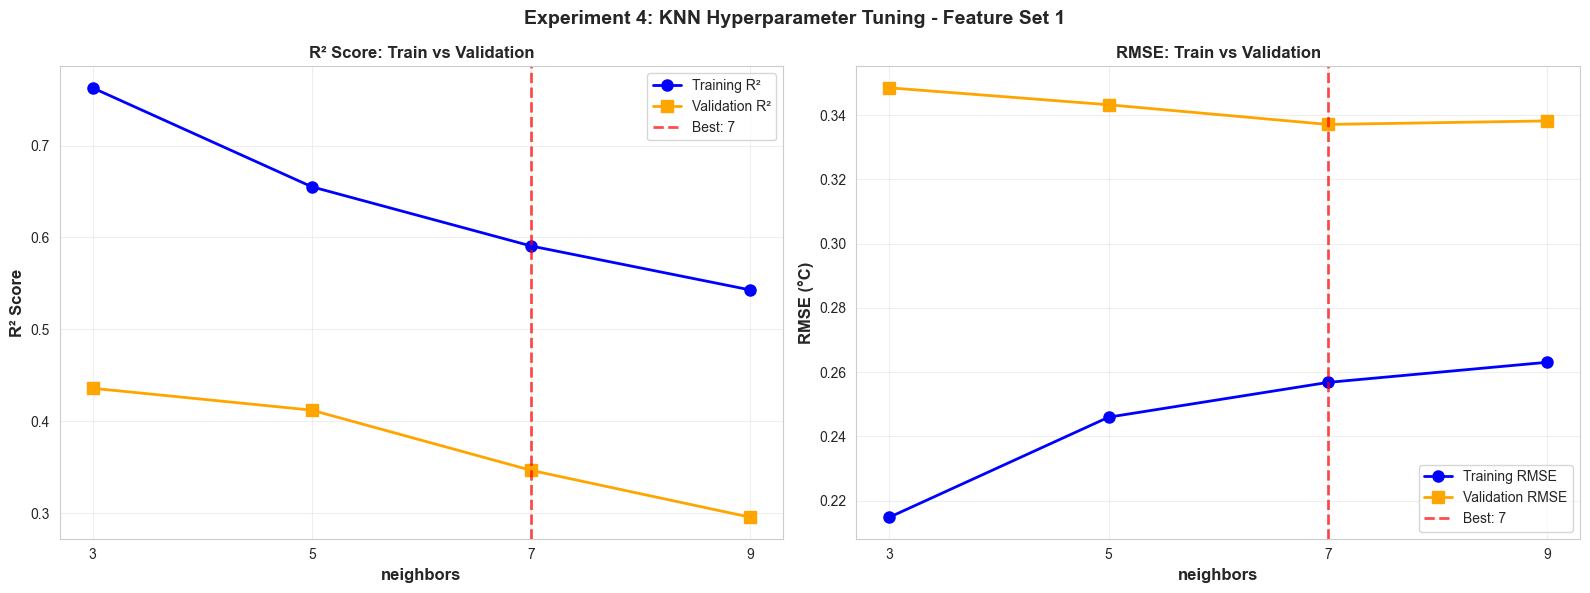

In [79]:
# KNN Model

# Hyperparameter tuning using validation set
neighbors = [3, 5, 7, 9]
train_scores_exp4 = []
val_scores_exp4 = []
train_rmse_exp4 = []
val_rmse_exp4 = []

print("\nHyperparameter Tuning:")
print("-"*70)
print(f"{'neighbors':<12} {'Train R²':<12} {'Val R²':<12} {'Train RMSE':<12} {'Val RMSE':<12}")
print("-"*70)

for n in neighbors:
    knn_model_exp1 = KNeighborsRegressor(n_neighbors=n)
    knn_model_exp1.fit(X_train_exp1, y_train_exp1)
    
    # Evaluate on train and validation
    train_pred_exp1 = knn_model_exp1.predict(X_train_exp1)
    val_pred_exp1 = knn_model_exp1.predict(X_val_exp1)
    
    train_rmse_exp1 = np.sqrt(mean_squared_error(y_train_exp1, train_pred_exp1))
    val_rmse_exp1 = np.sqrt(mean_squared_error(y_val_exp1, val_pred_exp1))
    
    train_score_exp1 = r2_score(train_pred_exp1, y_train_exp1)
    val_score_exp1 = r2_score(val_pred_exp1, y_val_exp1)
    
    train_scores_exp4.append(train_score_exp1)
    val_scores_exp4.append(val_score_exp1)
    train_rmse_exp4.append(train_rmse_exp1)
    val_rmse_exp4.append(val_rmse_exp1)
    
    n_str = str(n) if n is not None else "None"
    print(f"{n_str:<12} {train_score_exp1:<12.4f} {val_score_exp1:<12.4f} {train_rmse_exp1:<12.4f} {val_rmse_exp1:<12.4f}")

# Select best number of neighbors based on validation performance
best_n_idx_exp4 = np.argmin(val_rmse_exp4)
best_n_exp4 = neighbors[best_n_idx_exp4]
print(f"\nBest neighbors (based on validation RMSE): {best_n_exp4}")

# Plot Train/Validation curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Experiment 4: KNN Hyperparameter Tuning - Feature Set 1', 
             fontsize=14, fontweight='bold')

# Convert None to a plottable value for visualization
x_labels = [str(n) if n is not None else "None" for n in neighbors]
x_pos = np.arange(len(neighbors))

# Plot 1: R² Score
ax1 = axes[0]
ax1.plot(x_pos, train_scores_exp4, 'o-', label='Training R²', linewidth=2, markersize=8, color='blue')
ax1.plot(x_pos, val_scores_exp4, 's-', label='Validation R²', linewidth=2, markersize=8, color='orange')
ax1.axvline(x=best_n_idx_exp4, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Best: {best_n_exp4}')
ax1.set_xlabel('neighbors', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score: Train vs Validation', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: RMSE
ax2 = axes[1]
ax2.plot(x_pos, train_rmse_exp4, 'o-', label='Training RMSE', linewidth=2, markersize=8, color='blue')
ax2.plot(x_pos, val_rmse_exp4, 's-', label='Validation RMSE', linewidth=2, markersize=8, color='orange')
ax2.axvline(x=best_n_idx_exp4, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Best: {best_n_exp4}')
ax2.set_xlabel('neighbors', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE (°C)', fontsize=12, fontweight='bold')
ax2.set_title('RMSE: Train vs Validation', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Train final model with best hyperparameter and evaluate on test set
knn_model_exp4 = KNeighborsRegressor(n_neighbors=best_n_exp4)
knn_model_exp4.fit(X_train_exp1, y_train_exp1)

y_train_pred_knn_exp4 = knn_model_exp4.predict(X_train_exp1)
y_val_pred_knn_exp4 = knn_model_exp4.predict(X_val_exp1)

# Make predictions on test set
y_test_pred_knn_exp4 = knn_model_exp4.predict(X_test_exp1)

# Calculate metrics
knn_train_metrics_exp4 = calculate_metrics(y_train_exp1, y_train_pred_knn_exp4, 'Train')
knn_val_metrics_exp4 = calculate_metrics(y_val_exp1, y_val_pred_knn_exp4, 'Validation')
knn_test_metrics_exp4 = calculate_metrics(y_test_exp1, y_test_pred_knn_exp4, 'Test')

#### Experiment 5: KNN with Feature Set 2 (6 features)


Hyperparameter Tuning:
----------------------------------------------------------------------
neighbors    Train R²     Val R²       Train RMSE   Val RMSE    
----------------------------------------------------------------------
3            0.7738       0.4842       0.2051       0.3534      
5            0.6826       0.4649       0.2312       0.3343      
7            0.6015       0.4682       0.2471       0.3269      
9            0.5592       0.4282       0.2561       0.3261      

Best neighbors (based on validation RMSE): 9


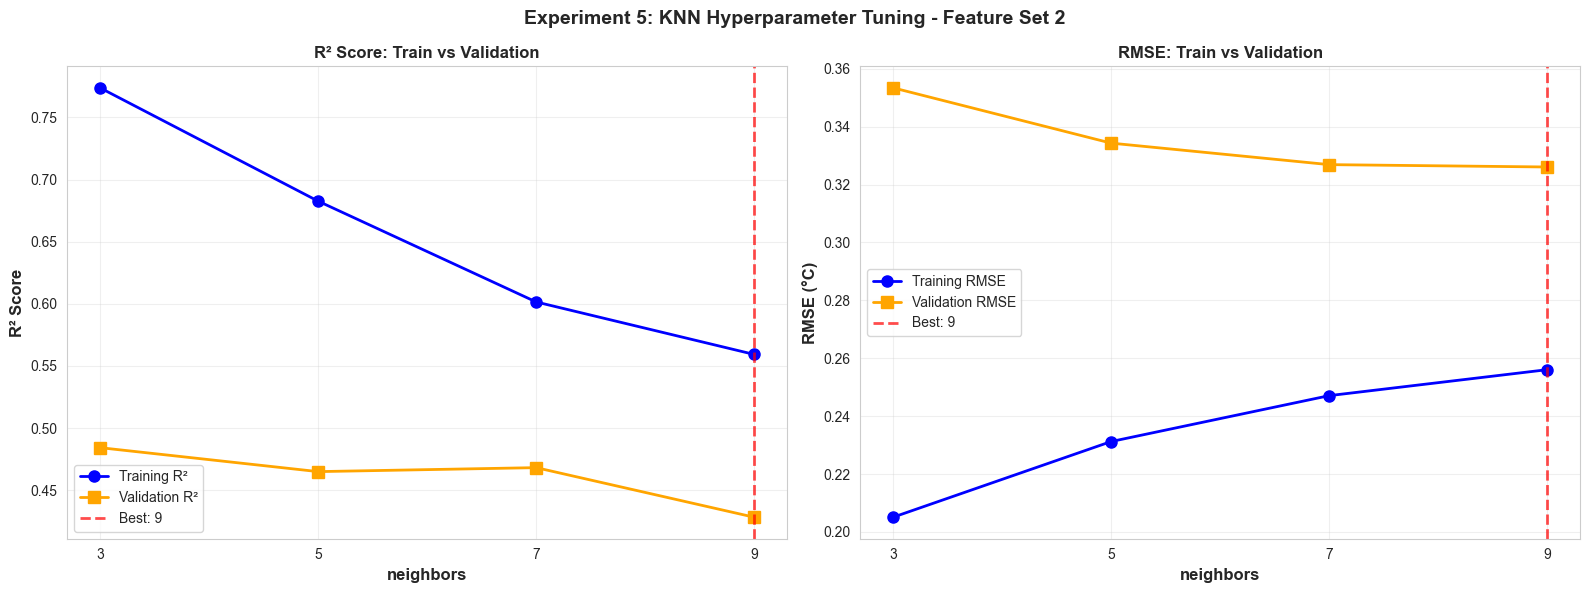

In [80]:
# KNN Model

# Hyperparameter tuning using validation set
neighbors = [3, 5, 7, 9]
train_scores_exp5 = []
val_scores_exp5 = []
train_rmse_exp5 = []
val_rmse_exp5 = []

print("\nHyperparameter Tuning:")
print("-"*70)
print(f"{'neighbors':<12} {'Train R²':<12} {'Val R²':<12} {'Train RMSE':<12} {'Val RMSE':<12}")
print("-"*70)

for n in neighbors:
    knn_model_exp2 = KNeighborsRegressor(n_neighbors=n)
    knn_model_exp2.fit(X_train_exp2, y_train_exp2)
    
    # Evaluate on train and validation
    train_pred_exp2 = knn_model_exp2.predict(X_train_exp2)
    val_pred_exp2 = knn_model_exp2.predict(X_val_exp2)
    
    train_rmse_exp2 = np.sqrt(mean_squared_error(y_train_exp2, train_pred_exp2))
    val_rmse_exp2 = np.sqrt(mean_squared_error(y_val_exp2, val_pred_exp2))
    
    train_score_exp2 = r2_score(train_pred_exp2, y_train_exp2)
    val_score_exp2 = r2_score(val_pred_exp2, y_val_exp2)
    
    train_scores_exp5.append(train_score_exp2)
    val_scores_exp5.append(val_score_exp2)
    train_rmse_exp5.append(train_rmse_exp2)
    val_rmse_exp5.append(val_rmse_exp2)
    
    n_str = str(n) if n is not None else "None"
    print(f"{n_str:<12} {train_score_exp2:<12.4f} {val_score_exp2:<12.4f} {train_rmse_exp2:<12.4f} {val_rmse_exp2:<12.4f}")

# Select best number of neighbors based on validation performance
best_n_idx_exp5 = np.argmin(val_rmse_exp5)
best_n_exp5 = neighbors[best_n_idx_exp5]
print(f"\nBest neighbors (based on validation RMSE): {best_n_exp5}")

# Plot Train/Validation curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Experiment 5: KNN Hyperparameter Tuning - Feature Set 2', 
             fontsize=14, fontweight='bold')

# Convert None to a plottable value for visualization
x_labels = [str(n) if n is not None else "None" for n in neighbors]
x_pos = np.arange(len(neighbors))

# Plot 1: R² Score
ax1 = axes[0]
ax1.plot(x_pos, train_scores_exp5, 'o-', label='Training R²', linewidth=2, markersize=8, color='blue')
ax1.plot(x_pos, val_scores_exp5, 's-', label='Validation R²', linewidth=2, markersize=8, color='orange')
ax1.axvline(x=best_n_idx_exp5, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Best: {best_n_exp5}')
ax1.set_xlabel('neighbors', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score: Train vs Validation', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: RMSE
ax2 = axes[1]
ax2.plot(x_pos, train_rmse_exp5, 'o-', label='Training RMSE', linewidth=2, markersize=8, color='blue')
ax2.plot(x_pos, val_rmse_exp5, 's-', label='Validation RMSE', linewidth=2, markersize=8, color='orange')
ax2.axvline(x=best_n_idx_exp5, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Best: {best_n_exp5}')
ax2.set_xlabel('neighbors', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE (°C)', fontsize=12, fontweight='bold')
ax2.set_title('RMSE: Train vs Validation', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Train final model with best hyperparameter and evaluate on test set
knn_model_exp5 = KNeighborsRegressor(n_neighbors=best_n_exp5)
knn_model_exp5.fit(X_train_exp2, y_train_exp2)

y_train_pred_knn_exp5 = knn_model_exp5.predict(X_train_exp2)
y_val_pred_knn_exp5 = knn_model_exp5.predict(X_val_exp2)

# Make predictions on test set
y_test_pred_knn_exp5 = knn_model_exp5.predict(X_test_exp2)

# Calculate metrics
knn_train_metrics_exp5 = calculate_metrics(y_train_exp2, y_train_pred_knn_exp5, 'Train')
knn_val_metrics_exp5 = calculate_metrics(y_val_exp2, y_val_pred_knn_exp5, 'Validation')
knn_test_metrics_exp5 = calculate_metrics(y_test_exp2, y_test_pred_knn_exp5, 'Test')

#### Experiment 6: KNN with Feature Set 3 (38 features)


Hyperparameter Tuning:
----------------------------------------------------------------------
neighbors    Train R²     Val R²       Train RMSE   Val RMSE    
----------------------------------------------------------------------
3            0.7369       0.5144       0.2119       0.3265      
5            0.6270       0.4862       0.2362       0.3144      
7            0.5764       0.4390       0.2455       0.3211      
9            0.5270       0.3971       0.2564       0.3252      

Best neighbors (based on validation RMSE): 5


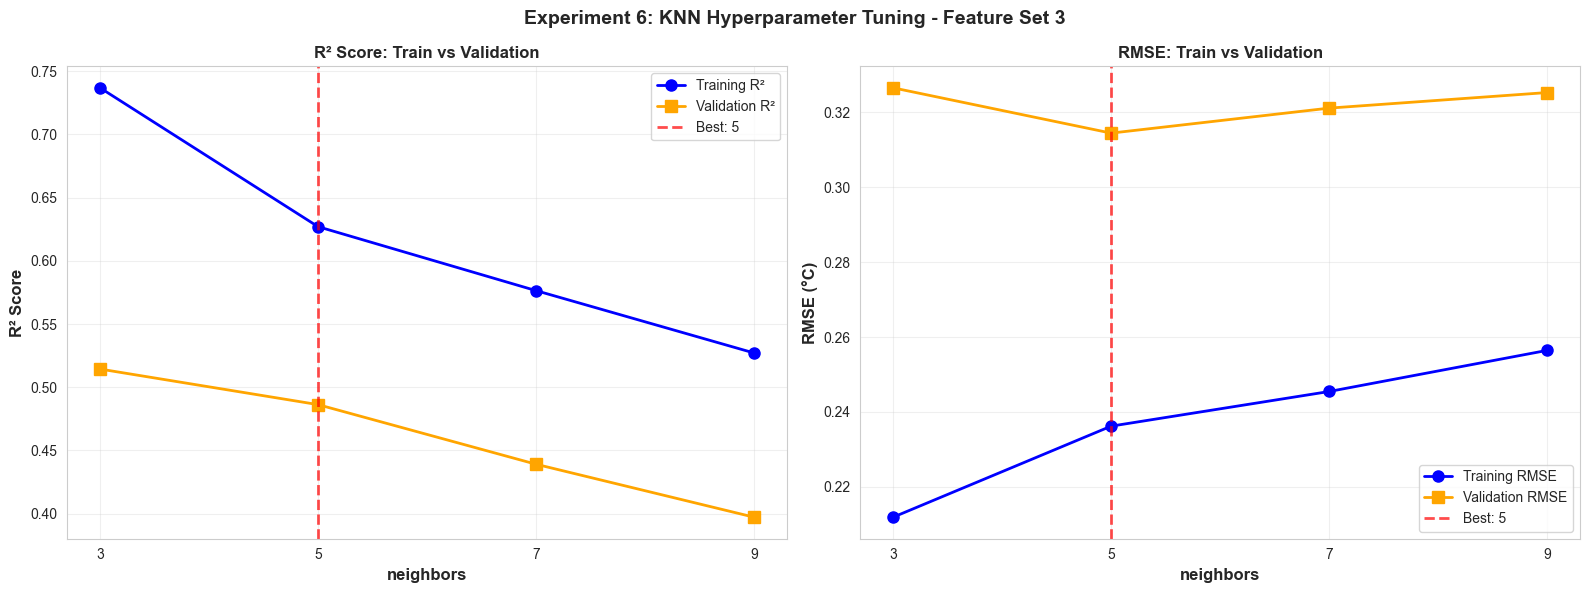

In [81]:
# KNN Model

# Hyperparameter tuning using validation set
neighbors = [3, 5, 7, 9]
train_scores_exp6 = []
val_scores_exp6 = []
train_rmse_exp6 = []
val_rmse_exp6 = []

print("\nHyperparameter Tuning:")
print("-"*70)
print(f"{'neighbors':<12} {'Train R²':<12} {'Val R²':<12} {'Train RMSE':<12} {'Val RMSE':<12}")
print("-"*70)

for n in neighbors:
    knn_model_exp3 = KNeighborsRegressor(n_neighbors=n)
    knn_model_exp3.fit(X_train_exp3, y_train_exp3)
    
    # Evaluate on train and validation
    train_pred_exp3 = knn_model_exp3.predict(X_train_exp3)
    val_pred_exp3 = knn_model_exp3.predict(X_val_exp3)
    
    train_rmse_exp3 = np.sqrt(mean_squared_error(y_train_exp3, train_pred_exp3))
    val_rmse_exp3 = np.sqrt(mean_squared_error(y_val_exp3, val_pred_exp3))
    
    train_score_exp3 = r2_score(train_pred_exp3, y_train_exp3)
    val_score_exp3 = r2_score(val_pred_exp3, y_val_exp3)
    
    train_scores_exp6.append(train_score_exp3)
    val_scores_exp6.append(val_score_exp3)
    train_rmse_exp6.append(train_rmse_exp3)
    val_rmse_exp6.append(val_rmse_exp3)
    
    n_str = str(n) if n is not None else "None"
    print(f"{n_str:<12} {train_score_exp3:<12.4f} {val_score_exp3:<12.4f} {train_rmse_exp3:<12.4f} {val_rmse_exp3:<12.4f}")

# Select best number of neighbors based on validation performance
best_n_idx_exp6 = np.argmin(val_rmse_exp6)
best_n_exp6 = neighbors[best_n_idx_exp6]
print(f"\nBest neighbors (based on validation RMSE): {best_n_exp6}")

# Plot Train/Validation curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Experiment 6: KNN Hyperparameter Tuning - Feature Set 3', 
             fontsize=14, fontweight='bold')

# Convert None to a plottable value for visualization
x_labels = [str(n) if n is not None else "None" for n in neighbors]
x_pos = np.arange(len(neighbors))

# Plot 1: R² Score
ax1 = axes[0]
ax1.plot(x_pos, train_scores_exp6, 'o-', label='Training R²', linewidth=2, markersize=8, color='blue')
ax1.plot(x_pos, val_scores_exp6, 's-', label='Validation R²', linewidth=2, markersize=8, color='orange')
ax1.axvline(x=best_n_idx_exp6, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Best: {best_n_exp6}')
ax1.set_xlabel('neighbors', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score: Train vs Validation', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: RMSE
ax2 = axes[1]
ax2.plot(x_pos, train_rmse_exp6, 'o-', label='Training RMSE', linewidth=2, markersize=8, color='blue')
ax2.plot(x_pos, val_rmse_exp6, 's-', label='Validation RMSE', linewidth=2, markersize=8, color='orange')
ax2.axvline(x=best_n_idx_exp6, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Best: {best_n_exp6}')
ax2.set_xlabel('neighbors', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE (°C)', fontsize=12, fontweight='bold')
ax2.set_title('RMSE: Train vs Validation', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Train final model with best hyperparameter and evaluate on test set
knn_model_exp6 = KNeighborsRegressor(n_neighbors=best_n_exp6)
knn_model_exp6.fit(X_train_exp3, y_train_exp3)

y_train_pred_knn_exp6 = knn_model_exp6.predict(X_train_exp3)
y_val_pred_knn_exp6 = knn_model_exp6.predict(X_val_exp3)

# Make predictions on test set
y_test_pred_knn_exp6 = knn_model_exp6.predict(X_test_exp3)

# Calculate metrics
knn_train_metrics_exp6 = calculate_metrics(y_train_exp3, y_train_pred_knn_exp6, 'Train')
knn_val_metrics_exp6 = calculate_metrics(y_val_exp3, y_val_pred_knn_exp6, 'Validation')
knn_test_metrics_exp6 = calculate_metrics(y_test_exp3, y_test_pred_knn_exp6, 'Test')

<a id="step-4"></a>

### Step 5: Evaluate the models' performance

In [88]:
from IPython.display import display

print("\n\n" + "="*80)
print("COMPARATIVE ANALYSIS OF ALL 6 EXPERIMENTS")
print("="*80)

# Create comparison table
comparison_data = {
    'Experiment': [
        'Exp 1: LR + Set 1 (4 feat)',
        'Exp 2: LR + Set 2 (6 feat)',
        'Exp 3: LR + Set 3 (38 feat)',
        'Exp 4: KNN + Set 1 (4 feat)',
        'Exp 5: KNN + Set 2 (6 feat)',
        'Exp 6: KNN + Set 3 (38 feat)'
    ],
    'Model': ['Linear Reg', 'Linear Reg', 'Linear Reg', 'KNN', 'KNN', 'KNN'],
    'Features': [4, 6, 38, 4, 6, 38],
    'Neighbors': ['-', '-', '-', best_n_exp4, best_n_exp5, best_n_exp6],
    'Train RMSE': [
        lr_train_metrics_exp1['RMSE'],
        lr_train_metrics_exp2['RMSE'],
        lr_train_metrics_exp3['RMSE'],
        knn_train_metrics_exp4['RMSE'],
        knn_train_metrics_exp5['RMSE'],
        knn_train_metrics_exp6['RMSE']
    ],
    'Test RMSE': [
        lr_test_metrics_exp1['RMSE'],
        lr_test_metrics_exp2['RMSE'],
        lr_test_metrics_exp3['RMSE'],
        knn_test_metrics_exp4['RMSE'],
        knn_test_metrics_exp5['RMSE'],
        knn_test_metrics_exp6['RMSE']
    ],
    'Train MAE': [
        lr_train_metrics_exp1['MAE'],
        lr_train_metrics_exp2['MAE'],
        lr_train_metrics_exp3['MAE'],
        knn_train_metrics_exp4['MAE'],
        knn_train_metrics_exp5['MAE'],
        knn_train_metrics_exp6['MAE']
    ],
    'Test MAE': [
        lr_test_metrics_exp1['MAE'],
        lr_test_metrics_exp2['MAE'],
        lr_test_metrics_exp3['MAE'],
        knn_test_metrics_exp4['MAE'],
        knn_test_metrics_exp5['MAE'],
        knn_test_metrics_exp6['MAE']
    ],
    'Train R²': [
        lr_train_metrics_exp1['R²'],
        lr_train_metrics_exp2['R²'],
        lr_train_metrics_exp3['R²'],
        knn_train_metrics_exp4['R²'],
        knn_train_metrics_exp5['R²'],
        knn_train_metrics_exp6['R²']
    ],
    'Test R²': [
        lr_test_metrics_exp1['R²'],
        lr_test_metrics_exp2['R²'],
        lr_test_metrics_exp3['R²'],
        knn_test_metrics_exp4['R²'],
        knn_test_metrics_exp5['R²'],
        knn_test_metrics_exp6['R²']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Add overfitting indicator
comparison_df['Overfit Gap (R²)'] = comparison_df['Train R²'] - comparison_df['Test R²']
comparison_df['Overfit Gap (RMSE)'] = comparison_df['Test RMSE'] - comparison_df['Train RMSE']

print("\nExperiment Comparison Results Table")
print("-"*80)
display(comparison_df)

# Find best models
print("\n" + "="*80)
print("Best models:")
print("-"*80)
best_test_rmse = comparison_df.loc[comparison_df['Test RMSE'].idxmin()]
best_test_mae = comparison_df.loc[comparison_df['Test MAE'].idxmin()]
best_test_r2 = comparison_df.loc[comparison_df['Test R²'].idxmax()]
min_overfit = comparison_df.loc[comparison_df['Overfit Gap (R²)'].idxmin()]
min_overfit2 = comparison_df.loc[comparison_df['Overfit Gap (RMSE)'].idxmin()]

print(f"Lowest Test RMSE:     {best_test_rmse['Experiment']} (RMSE={best_test_rmse['Test RMSE']:.4f})")
print(f"Lowest Test MAE:      {best_test_mae['Experiment']} (MAE={best_test_mae['Test MAE']:.4f})")
print(f"Highest Test R²:      {best_test_r2['Experiment']} (R²={best_test_r2['Test R²']:.4f})")
print(f"Least Overfitting:    {min_overfit['Experiment']} (Gap(R², RMSE)={min_overfit['Overfit Gap (R²)']:.4f}, {min_overfit2['Overfit Gap (RMSE)']:.4f})")



COMPARATIVE ANALYSIS OF ALL 6 EXPERIMENTS

Experiment Comparison Results Table
--------------------------------------------------------------------------------


,Experiment,Model,Features,Neighbors,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²,Overfit Gap (R²),Overfit Gap (RMSE)
0,Exp 1: LR + Set 1 (4 feat),Linear Reg,4,-,0.299253,0.294695,0.235093,0.218157,0.635000,0.626087,0.008914,-0.004559
1,Exp 2: LR + Set 2 (6 feat),Linear Reg,6,-,0.303545,0.295641,0.235476,0.221353,0.624457,0.623682,0.000775,-0.007904
2,Exp 3: LR + Set 3 (38 feat),Linear Reg,38,-,0.281072,0.268097,0.220101,0.201946,0.678004,0.690536,-0.012531,-0.012975
3,Exp 4: KNN + Set 1 (4 feat),KNN,4,7,0.256771,0.271904,0.196073,0.206071,0.731277,0.681684,0.049593,0.015134
4,Exp 5: KNN + Set 2 (6 feat),KNN,6,9,0.256059,0.284552,0.192011,0.204563,0.732765,0.651382,0.081383,0.028493
5,Exp 6: KNN + Set 3 (38 feat),KNN,38,5,0.236222,0.297870,0.179342,0.202071,0.772567,0.617986,0.154581,0.061648



Best models:
--------------------------------------------------------------------------------
Lowest Test RMSE:     Exp 3: LR + Set 3 (38 feat) (RMSE=0.2681)
Lowest Test MAE:      Exp 3: LR + Set 3 (38 feat) (MAE=0.2019)
Highest Test R²:      Exp 3: LR + Set 3 (38 feat) (R²=0.6905)
Least Overfitting:    Exp 3: LR + Set 3 (38 feat) (Gap(R², RMSE)=-0.0125, -0.0130)


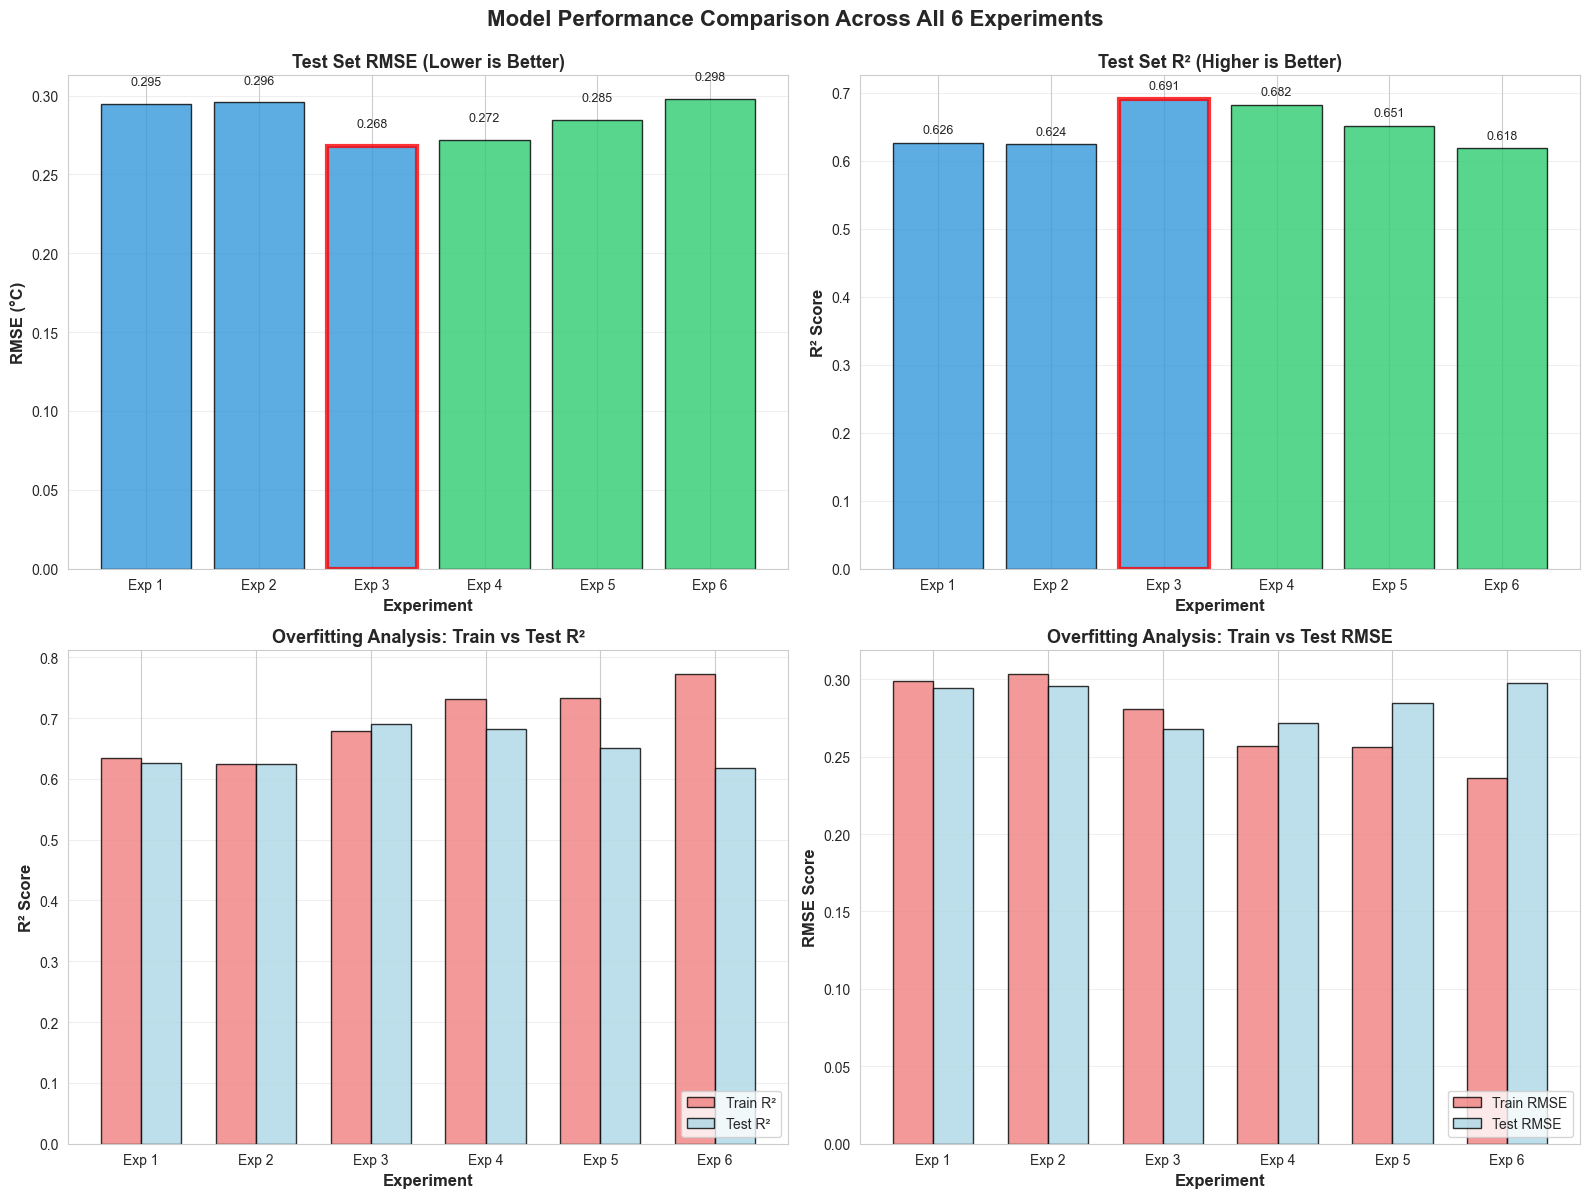

In [90]:
# Model Performance Comparison

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison Across All 6 Experiments', 
             fontsize=16, fontweight='bold', y=0.995)

# Color scheme: Linear Regression (blue), KNN (green)
colors = ['#3498db', '#3498db', '#3498db', '#2ecc71', '#2ecc71', '#2ecc71']

# Plot 1: Test RMSE
ax1 = axes[0, 0]
bars1 = ax1.bar(range(len(comparison_df)), comparison_df['Test RMSE'], color=colors, alpha=0.8, edgecolor='black')
ax1.set_xlabel('Experiment', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE (°C)', fontsize=12, fontweight='bold')
ax1.set_title('Test Set RMSE (Lower is Better)', fontsize=13, fontweight='bold')
ax1.set_xticks(range(len(comparison_df)))
ax1.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6'])
ax1.grid(axis='y', alpha=0.3)
# Highlight best
best_idx = comparison_df['Test RMSE'].idxmin()
bars1[best_idx].set_edgecolor('red')
bars1[best_idx].set_linewidth(3)
for i, v in enumerate(comparison_df['Test RMSE']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Test R²
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(comparison_df)), comparison_df['Test R²'], color=colors, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Experiment', fontsize=12, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax2.set_title('Test Set R² (Higher is Better)', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(comparison_df)))
ax2.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6'])
ax2.grid(axis='y', alpha=0.3)
# Highlight best
best_idx = comparison_df['Test R²'].idxmax()
bars2[best_idx].set_edgecolor('red')
bars2[best_idx].set_linewidth(3)
for i, v in enumerate(comparison_df['Test R²']):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Overfitting Analysis (Train RMSE vs Test RMSE)
ax3 = axes[1, 1]
x_pos = np.arange(len(comparison_df))
width = 0.35
bars_train = ax3.bar(x_pos - width/2, comparison_df['Train RMSE'], width, 
                     label='Train RMSE', color='lightcoral', alpha=0.8, edgecolor='black')
bars_test = ax3.bar(x_pos + width/2, comparison_df['Test RMSE'], width, 
                    label='Test RMSE', color='lightblue', alpha=0.8, edgecolor='black')
ax3.set_xlabel('Experiment', fontsize=12, fontweight='bold')
ax3.set_ylabel('RMSE Score', fontsize=12, fontweight='bold')
ax3.set_title('Overfitting Analysis: Train vs Test RMSE', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6'])
ax3.legend(loc='lower right', fontsize=10)
ax3.grid(axis='y', alpha=0.3)    
    
# Plot 4: Overfitting Analysis (Train R² vs Test R²)
ax4 = axes[1, 0]
x_pos = np.arange(len(comparison_df))
width = 0.35
bars_train = ax4.bar(x_pos - width/2, comparison_df['Train R²'], width, 
                     label='Train R²', color='lightcoral', alpha=0.8, edgecolor='black')
bars_test = ax4.bar(x_pos + width/2, comparison_df['Test R²'], width, 
                    label='Test R²', color='lightblue', alpha=0.8, edgecolor='black')
ax4.set_xlabel('Experiment', fontsize=12, fontweight='bold')
ax4.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax4.set_title('Overfitting Analysis: Train vs Test R²', fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 'Exp 5', 'Exp 6'])
ax4.legend(loc='lower right', fontsize=10)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

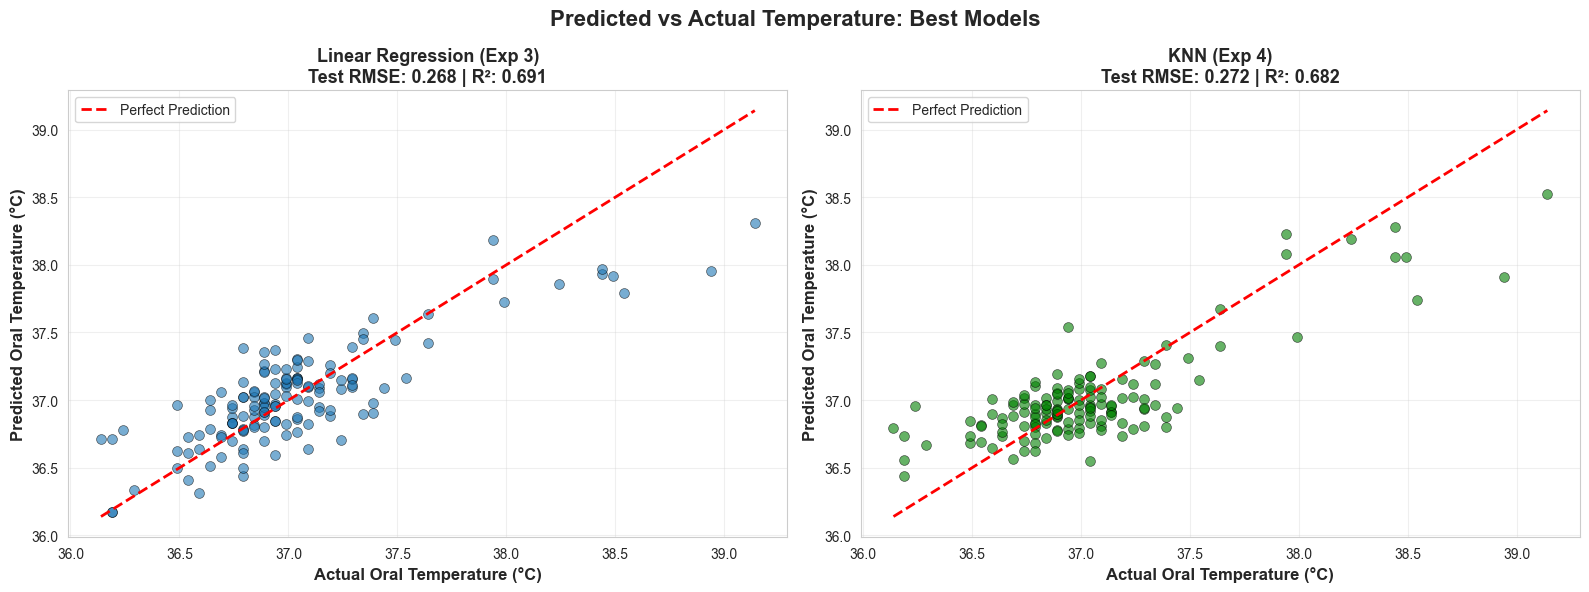

In [92]:
# Predicted vs Actual - Best Models from Each Type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Predicted vs Actual Temperature: Best Models', 
             fontsize=16, fontweight='bold')

# Best Linear Regression
ax1 = axes[0]
ax1.scatter(y_test_exp3, y_test_pred_lr_exp3, alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
ax1.plot([y_test_exp3.min(), y_test_exp3.max()], 
         [y_test_exp3.min(), y_test_exp3.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Oral Temperature (°C)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Oral Temperature (°C)', fontsize=12, fontweight='bold')
ax1.set_title(f'Linear Regression (Exp 3)\nTest RMSE: {lr_test_metrics_exp3["RMSE"]:.3f} | R²: {lr_test_metrics_exp3["R²"]:.3f}', 
              fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Best KNN (based on test performance)
best_knn_idx = comparison_df[comparison_df['Model'] == 'KNN']['Test RMSE'].idxmin()
if best_knn_idx == 3:  # Exp 4
    y_test_knn, y_test_pred_knn = y_test_exp1, y_test_pred_knn_exp4
    knn_metrics = knn_test_metrics_exp4
    exp_name = "Exp 4"
elif best_knn_idx == 4:  # Exp 5
    y_test_knn, y_test_pred_knn = y_test_exp2, y_test_pred_knn_exp5
    knn_metrics = knn_test_metrics_exp5
    exp_name = "Exp 5"
else:  # Exp 6
    y_test_knn, y_test_pred_knn = y_test_exp3, y_test_pred_knn_exp6
    knn_metrics = knn_test_metrics_exp6
    exp_name = "Exp 6"

ax2 = axes[1]
ax2.scatter(y_test_knn, y_test_pred_knn, alpha=0.6, s=50, edgecolor='black', linewidth=0.5, color='green')
ax2.plot([y_test_knn.min(), y_test_knn.max()], 
         [y_test_knn.min(), y_test_knn.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Oral Temperature (°C)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted Oral Temperature (°C)', fontsize=12, fontweight='bold')
ax2.set_title(f'KNN ({exp_name})\nTest RMSE: {knn_metrics["RMSE"]:.3f} | R²: {knn_metrics["R²"]:.3f}', 
              fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

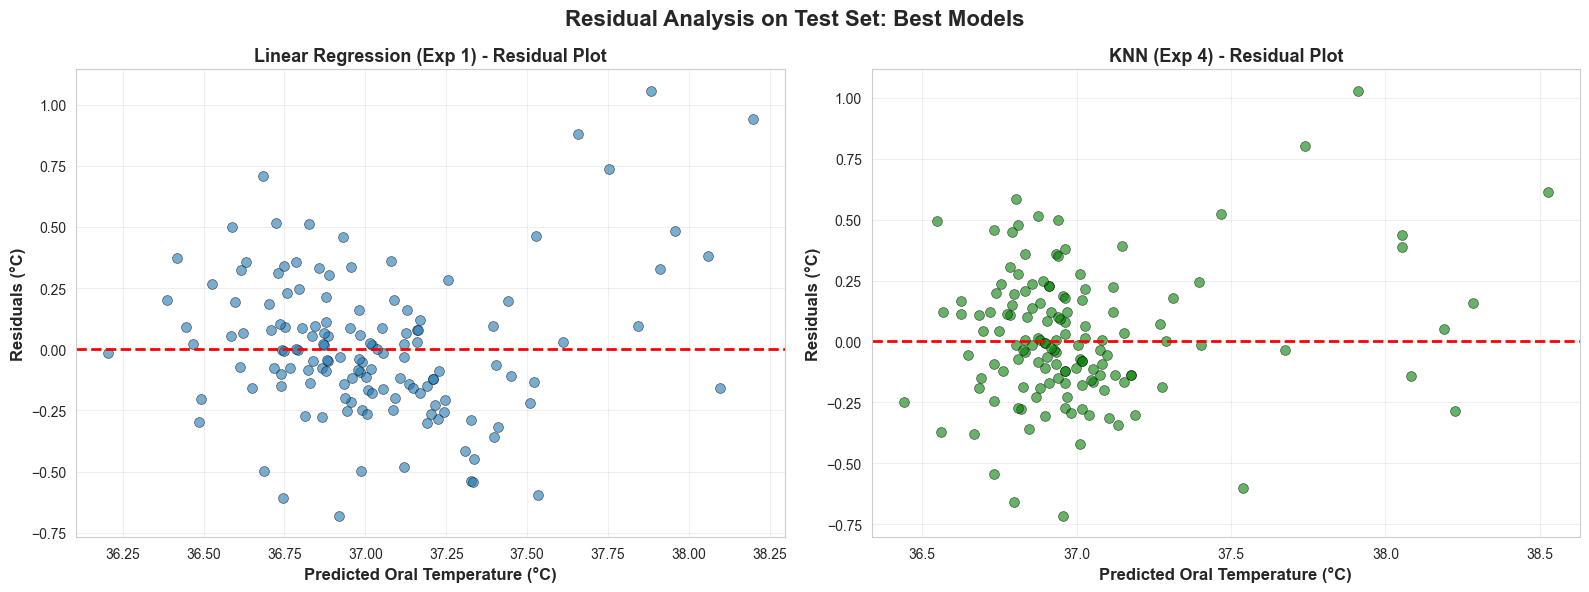

In [94]:
# Residual Analysis

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Residual Analysis on Test Set: Best Models', 
             fontsize=16, fontweight='bold')

# Linear Regression Residuals
residuals_lr = y_test_exp3 - y_test_pred_lr_exp1
ax1 = axes[0]
ax1.scatter(y_test_pred_lr_exp1, residuals_lr, alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
ax1.axhline(y=0, color='r', linestyle='--', lw=2)
ax1.set_xlabel('Predicted Oral Temperature (°C)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Residuals (°C)', fontsize=12, fontweight='bold')
ax1.set_title('Linear Regression (Exp 1) - Residual Plot', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# KNN Residuals
residuals_knn = y_test_exp1 - y_test_pred_knn
ax2 = axes[1]
ax2.scatter(y_test_pred_knn, residuals_knn, alpha=0.6, s=50, edgecolor='black', linewidth=0.5, color='green')
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Oral Temperature (°C)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Residuals (°C)', fontsize=12, fontweight='bold')
ax2.set_title(f'KNN ({exp_name}) - Residual Plot', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [97]:
# ======================
# FINAL RECOMMENDATION
# =====================
print("\n" + "="*80)
print("MODEL SELECTION RECOMMENDATION")
print("="*80)

# Calculate overall best model based on multiple criteria
comparison_df['Rank_RMSE'] = comparison_df['Test RMSE'].rank(ascending=True)
comparison_df['Rank_MAE'] = comparison_df['Test MAE'].rank(ascending=True)
comparison_df['Rank_R2'] = comparison_df['Test R²'].rank(ascending=False)
comparison_df['Rank_Overfit'] = comparison_df['Overfit Gap (RMSE)'].abs().rank(ascending=False)
comparison_df['Overall_Rank'] = (comparison_df['Rank_RMSE'] + 
                                 comparison_df['Rank_MAE'] + 
                                 comparison_df['Rank_R2'] + 
                                 comparison_df['Rank_Overfit']) / 4

best_overall = comparison_df.loc[comparison_df['Overall_Rank'].idxmin()]

print("\nOVERALL BEST MODEL (based on balanced ranking):")
print("-"*80)
print(f"Experiment:       {best_overall['Experiment']}")
print(f"Model Type:       {best_overall['Model']}")
print(f"Number Features:  {int(best_overall['Features'])}")
print(f"Best number of neighbors:        {best_overall['Neighbors']}")
print(f"Test RMSE:        {best_overall['Test RMSE']:.4f} °C")
print(f"Test MAE:         {best_overall['Test MAE']:.4f} °C")
print(f"Test R²:          {best_overall['Test R²']:.4f}")
print(f"Overfitting Gap:  {best_overall['Overfit Gap (RMSE)']:.4f}")


MODEL SELECTION RECOMMENDATION

OVERALL BEST MODEL (based on balanced ranking):
--------------------------------------------------------------------------------
Experiment:       Exp 3: LR + Set 3 (38 feat)
Model Type:       Linear Reg
Number Features:  38
Best number of neighbors:        -
Test RMSE:        0.2681 °C
Test MAE:         0.2019 °C
Test R²:          0.6905
Overfitting Gap:  -0.0130
